# Spherical Gaussian experiment (2D)

## Setup

In [1]:
import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging


sys.path.append("../../")
from manifold_flow import transforms, utils, distributions, training
from manifold_flow.flows import Flow, ManifoldFlow
from manifold_flow import nn as nn_
from experiments.simulators.spherical_simulator import SphericalGaussianSimulator
from experiments.utils.models import create_vector_transform

%matplotlib inline

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "experiments" not in key and "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


### Settings

In [2]:
epochs = 12
n_train = 100000
epsilon = 0.01
train = False

### Data

In [3]:
simulator = SphericalGaussianSimulator(latent_dim=1, data_dim=2, epsilon=epsilon)
x_sim = simulator.sample(n_train)
x_sim_tensor = torch.from_numpy(x_sim)
train_dataset = TensorDataset(x_sim_tensor, x_sim_tensor)

../../experiments/simulators/spherical_simulator.py:99: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=self._epsilon).pdf(z_eps))


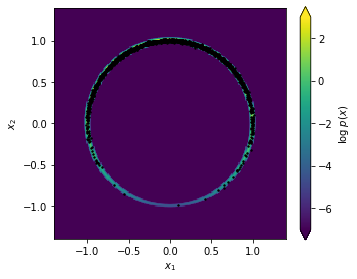

In [4]:
res = 200
x_range = np.linspace(-1.4,1.4,res)
y_range = np.linspace(-1.4,1.4,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
logp_grid = simulator.log_density(x_grid, precise=True).reshape((res, res))
logp_grid[~np.isfinite(logp_grid)] = -1000000.

zmin, zmax = np.max(logp_grid) - 10, np.max(logp_grid)
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.imshow(
    np.clip(logp_grid, zmin, zmax),
    extent=(-1.4,1.4,-1.4,1.4),
    origin="lower",
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest'
)
cb = plt.colorbar(pcm, extend="both")
plt.scatter(x_sim[::50,0], x_sim[::50,1], s=2., c="black", alpha=1.)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; p(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_data.pdf", dpi=500)

In [5]:
pixel_size = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

print("Integral over density =", np.sum(np.exp(logp_grid) * pixel_size))

Integral over density = 1.0000930850098504


## Set up models

### Manifold flow

In [16]:
outer_transform = create_vector_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None,
    hidden_features=100,
    num_transform_blocks=1,
    resnet_transform=False,
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

mf = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=inner_transform,
    outer_transform=outer_transform
)

In [17]:
if train:
    trainer = training.trainer.ManifoldFlowTrainer(mf)
    trainer.train(
        train_dataset,
        [training.losses.mse],
        loss_weights=[100.],
        epochs=epochs // 3,
        forward_kwargs={"mode":"projection"}
    )
    trainer.train(
        train_dataset,
        [training.losses.mse, training.losses.nll],
        loss_weights=[100., 0.1],
        epochs=epochs // 3,
        forward_kwargs={"mode":"mf"}
    )
    trainer.train(
        train_dataset,
        [training.losses.mse, training.losses.nll],
        loss_weights=[0., 1.],
        epochs=epochs // 3,
        parameters=mf.inner_transform.parameters(),
        forward_kwargs={"mode":"mf"}
    )
    torch.save(mf.state_dict(), "../data/models/mf_1_spherical_gaussian_1_2_0.010.pt")
else:
    mf.load_state_dict(torch.load("../data/models/mf_1_spherical_gaussian_1_2_0.010.pt"))

### PIE

In [18]:
outer_transform = create_vector_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None,
    hidden_features=100,
    num_transform_blocks=1,
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

pie = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    outer_transform=outer_transform,
    inner_transform=inner_transform,
)

In [19]:
if train:
    trainer = training.trainer.ManifoldFlowTrainer(pie)
    trainer.train(
        train_dataset,
        [training.losses.nll],
        loss_weights=[1.],
        epochs=epochs,
        forward_kwargs={"mode":"pie"}
    )
    torch.save(pie.state_dict(), "../data/models/pie_1_spherical_gaussian_1_2_0.010.pt")
else:
    pie.load_state_dict(torch.load("../data/models/pie_1_spherical_gaussian_1_2_0.010.pt"))

### Slice of PIE

In [20]:
outer_transform = create_vector_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None,
    hidden_features=100,
    num_transform_blocks=1,
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

slice_of_pie = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    outer_transform=outer_transform,
    inner_transform=inner_transform,
)

In [21]:
if train:
    trainer = training.trainer.ManifoldFlowTrainer(slice_of_pie)
    trainer.train(
        train_dataset,
        [training.losses.mse],
        loss_weights=[100.],
        epochs=epochs // 3,
        forward_kwargs={"mode": "projection"}
    )
    trainer.train(
        train_dataset,
        [training.losses.mse, training.losses.nll],
        loss_weights=[100., 0.1],
        epochs=epochs // 3,
        forward_kwargs={"mode": "slice"}
    )
    trainer.train(
        train_dataset,
        [training.losses.mse, training.losses.nll],
        loss_weights=[0., 1.],
        epochs=epochs // 3,
        parameters=mf.inner_transform.parameters(),
        forward_kwargs={"mode": "slice"}
    )
    torch.save(slice_of_pie.state_dict(), "../data/models/slice_1_spherical_gaussian_1_2_0.010.pt")
else:
    slice_of_pie.load_state_dict(torch.load("../data/models/slice_1_spherical_gaussian_1_2_0.010.pt"))

### Pure GAMF

In [22]:
outer_transform = create_vector_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None,
    hidden_features=100,
    num_transform_blocks=1,
    resnet_transform=False,
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

gamf = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=inner_transform,
    outer_transform=outer_transform
)

In [23]:
if train:
    ftrainer = training.trainer.ManifoldFlowTrainer(gamf)
    ftrainer.train(
        train_dataset,
        [training.losses.mse],
        loss_weights=[100.],
        epochs=epochs // 4,
        forward_kwargs={"mode":"projection"}
    )
    gtrainer = training.trainer.GenerativeTrainer(gamf)
    gtrainer.train(
        train_dataset,
        [training.losses.make_sinkhorn_divergence()],
        loss_weights=[100.],
        epochs=epochs * 3 // 4,
        batch_size=1000,
    )
    torch.save(gamf.state_dict(), "../data/models/gamf_1_spherical_gaussian_1_2_0.010.pt")
else:
    gamf.load_state_dict(torch.load("../data/models/gamf_1_spherical_gaussian_1_2_0.010.pt"))

### Hybrid

In [24]:
outer_transform = create_vector_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None,
    hidden_features=100,
    num_transform_blocks=1,
    resnet_transform=False,
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

hybrid = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=inner_transform,
    outer_transform=outer_transform
)

In [25]:
if train:
    ftrainer = training.trainer.ManifoldFlowTrainer(hybrid)
    ftrainer.train(
        train_dataset,
        [training.losses.mse],
        loss_weights=[100.],
        epochs=epochs // 4,
        forward_kwargs={"mode":"projection"}
    )
    gtrainer = training.trainer.GenerativeTrainer(hybrid)
    gtrainer.train(
        train_dataset,
        [training.losses.make_sinkhorn_divergence()],
        loss_weights=[100.],
        epochs=epochs // 4,
        batch_size=1000,
    )
    ftrainer.train(
        train_dataset,
        [training.losses.mse, training.losses.nll],
        loss_weights=[100., 0.1],
        epochs=epochs // 4,
        forward_kwargs={"mode":"mf"}
    )
    ftrainer.train(
        train_dataset,
        [training.losses.mse, training.losses.nll],
        loss_weights=[0., 1.],
        epochs=epochs // 4,
        parameters=mf.inner_transform.parameters(),
        forward_kwargs={"mode":"mf"}
    )
    torch.save(hybrid.state_dict(), "../data/models/hybrid_1_spherical_gaussian_1_2_0.010.pt")
else:
    hybrid.load_state_dict(torch.load("../data/models/hybrid_1_spherical_gaussian_1_2_0.010.pt"))

### Standard flow

In [26]:
transform = create_vector_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None,
    hidden_features=100,
    num_transform_blocks=1,
)
sf = Flow(
    data_dim=2,
    transform=transform
)

In [27]:
if train:
    trainer = training.trainer.ManifoldFlowTrainer(sf)
    trainer.train(
        train_dataset,
        [training.losses.nll],
        loss_weights=[1.],
        epochs=epochs,
    )
    torch.save(sf.state_dict(), "../data/models/flow_1_spherical_gaussian_1_2_0.010.pt")
else:
    sf.load_state_dict(torch.load("../data/models/flow_1_spherical_gaussian_1_2_0.010.pt"))

### Standard flow with autoregressive transform

In [6]:
transform = create_vector_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-autoregressive",
    context_features=None,
    hidden_features=100,
    num_transform_blocks=1,
)
sf2 = Flow(
    data_dim=2,
    transform=transform
)

In [7]:
if train:
    trainer = training.trainer.ManifoldFlowTrainer(sf2)
    trainer.train(
        train_dataset,
        [training.losses.nll],
        loss_weights=[1.],
        epochs=epochs,
    )
    torch.save(sf2.state_dict(), "../data/models/flow_1_spherical_gaussian_1_2_0.010_maf.pt")
else:
    sf2.load_state_dict(torch.load("../data/models/flow_1_spherical_gaussian_1_2_0.010_maf.pt"))

09:46 manifold_flow.training.trainer INFO    Training on CPU with single precision
09:47 manifold_flow.training.trainer INFO    Epoch   1: train loss  2.41879 (nll:  2.419)
09:47 manifold_flow.training.trainer INFO               val. loss   2.27703 (nll:  2.277)
09:47 manifold_flow.training.trainer INFO    Epoch   2: train loss  2.19853 (nll:  2.199)
09:47 manifold_flow.training.trainer INFO               val. loss   2.12080 (nll:  2.121)
09:47 manifold_flow.training.trainer INFO    Epoch   3: train loss  2.07386 (nll:  2.074)
09:47 manifold_flow.training.trainer INFO               val. loss   2.03076 (nll:  2.031)
09:48 manifold_flow.training.trainer INFO    Epoch   4: train loss  2.00367 (nll:  2.004)
09:48 manifold_flow.training.trainer INFO               val. loss   1.97564 (nll:  1.976)
09:48 manifold_flow.training.trainer INFO    Epoch   5: train loss  1.96438 (nll:  1.964)
09:48 manifold_flow.training.trainer INFO               val. loss   1.95539 (nll:  1.955)
09:49 manifold_fl

## Standard flow with rational quadratic coupling transform

In [38]:
transform = create_vector_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="rq-coupling",
    context_features=None,
    hidden_features=100,
    num_transform_blocks=1,
)
sf3 = Flow(
    data_dim=2,
    transform=transform
)

In [40]:
if True:
    trainer = training.trainer.ManifoldFlowTrainer(sf3)
    trainer.train(
        train_dataset,
        [training.losses.nll],
        loss_weights=[1.],
        epochs=epochs,
    )
    torch.save(sf3.state_dict(), "../data/models/flow_1_spherical_gaussian_1_2_0.010_rqc.pt")
else:
    sf3.load_state_dict(torch.load("../data/models/flow_1_spherical_gaussian_1_2_0.010_rqc.pt"))

09:59 manifold_flow.training.trainer INFO    Training on CPU with single precision


TypeError: unconstrained_rational_quadratic_spline() got an unexpected keyword argument 'full_jacobian'

### Manifold flow with specified manifold

In [28]:
outer_transform=transforms.SphericalCoordinates(n=1, r0=1.)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

smf = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=inner_transform,
    outer_transform=outer_transform
)

In [29]:
if train:
    trainer = training.trainer.ManifoldFlowTrainer(smf)
    trainer.train(
        train_dataset,
        [training.losses.nll],
        loss_weights=[1.],
        epochs=epochs,
        forward_kwargs={"mode":"mf"}
    )
    torch.save(smf.state_dict(), "../data/models/smf_1_spherical_gaussian_1_2_0.010.pt")
else:
    smf.load_state_dict(torch.load("../data/models/smf_1_spherical_gaussian_1_2_0.010.pt"))

## Evaluate the generative performance

### Sample

In [30]:
x_gen_sf = sf.sample(n=1000).detach().numpy()
x_gen_sf2 = sf2.sample(n=1000).detach().numpy()
x_gen_mf = mf.sample(n=1000).detach().numpy()
x_gen_pie = pie.sample(n=1000).detach().numpy()
x_gen_pie_full = pie.sample(n=1000, sample_orthogonal=True).detach().numpy()
x_gen_gamf = gamf.sample(n=1000).detach().numpy()
x_gen_hybrid = hybrid.sample(n=1000).detach().numpy()
x_gen_smf = smf.sample(n=1000).detach().numpy()

### Distance from manifold, true likelihood of generated samples

In [31]:
def generative_metrics(x_gen, logp_min=-100., d_max=1., summary_fn=np.mean):
    logp_gen = simulator.log_density(x_gen)
    logp_gen[(~np.isfinite(logp_gen)) + (logp_gen<logp_min)] = logp_min
    logp_summary = summary_fn(logp_gen)
    
    d_gen = np.abs(np.sum(x_gen**2, axis=1)**0.5 - 1)
    d_gen[(~np.isfinite(d_gen)) + (d_gen>d_max)] = d_max
    d_summary = summary_fn(d_gen)
    
    return logp_summary, d_summary

In [32]:
logp_gen_sf, d_gen_sf = generative_metrics(x_gen_sf)
logp_gen_sf2, d_gen_sf2 = generative_metrics(x_gen_sf2)
logp_gen_mf, d_gen_mf = generative_metrics(x_gen_mf)
logp_gen_pie, d_gen_pie = generative_metrics(x_gen_pie)
logp_gen_pie_full, d_gen_pie_full = generative_metrics(x_gen_pie_full)
logp_gen_gamf, d_gen_gamf = generative_metrics(x_gen_gamf)
logp_gen_hybrid, d_gen_hybrid = generative_metrics(x_gen_gamf)
logp_gen_smf, d_gen_smf = generative_metrics(x_gen_smf)

print("Mean true log likelihood of samples generated from flows (higher is better):")
print("  Standard flow:      {:>6.1f}".format(logp_gen_sf))
print("  Standard flow 2:    {:>6.1f}".format(logp_gen_sf2))
print("  PIE (sampling all): {:>6.1f}".format(logp_gen_pie_full))
print("  PIE (sampling M):   {:>6.1f}".format(logp_gen_pie))
print("  Manifold flow:      {:>6.1f}".format(logp_gen_mf))
print("  Specified MF:       {:>6.1f}".format(logp_gen_smf))
print("  Gen. adv. MF:       {:>6.1f}".format(logp_gen_gamf))
print("  MF/GAMF hybrid:     {:>6.1f}".format(logp_gen_hybrid))

print("Mean Euclidean distance between samples generated from flows and true manifold (lower is better):")
print("  Standard flow:      {:>6.4f}".format(d_gen_sf))
print("  Standard flow 2:    {:>6.4f}".format(d_gen_sf2))
print("  PIE (sampling all): {:>6.4f}".format(d_gen_pie))
print("  PIE (sampling M):   {:>6.4f}".format(d_gen_pie))
print("  Manifold flow:      {:>6.4f}".format(d_gen_mf))
print("  Specified MF:       {:>6.4f}".format(d_gen_smf))
print("  Gen. adv. MF:       {:>6.4f}".format(d_gen_gamf))
print("  MF/GAMF hybrid:     {:>6.4f}".format(d_gen_hybrid))


Mean true log likelihood of samples generated from flows (higher is better):
  Standard flow:       -89.3
  Standard flow 2:     -86.0
  PIE (sampling all):   -9.6
  PIE (sampling M):     -8.6
  Manifold flow:         2.0
  Specified MF:          2.2
  Gen. adv. MF:         -0.8
  MF/GAMF hybrid:       -0.8
Mean Euclidean distance between samples generated from flows and true manifold (lower is better):
  Standard flow:      0.6378
  Standard flow 2:    0.5552
  PIE (sampling all): 0.0804
  PIE (sampling M):   0.0804
  Manifold flow:      0.0048
  Specified MF:       0.0000
  Gen. adv. MF:       0.0183
  MF/GAMF hybrid:     0.0183


../../experiments/simulators/spherical_simulator.py:99: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=self._epsilon).pdf(z_eps))


### Visualize generated samples

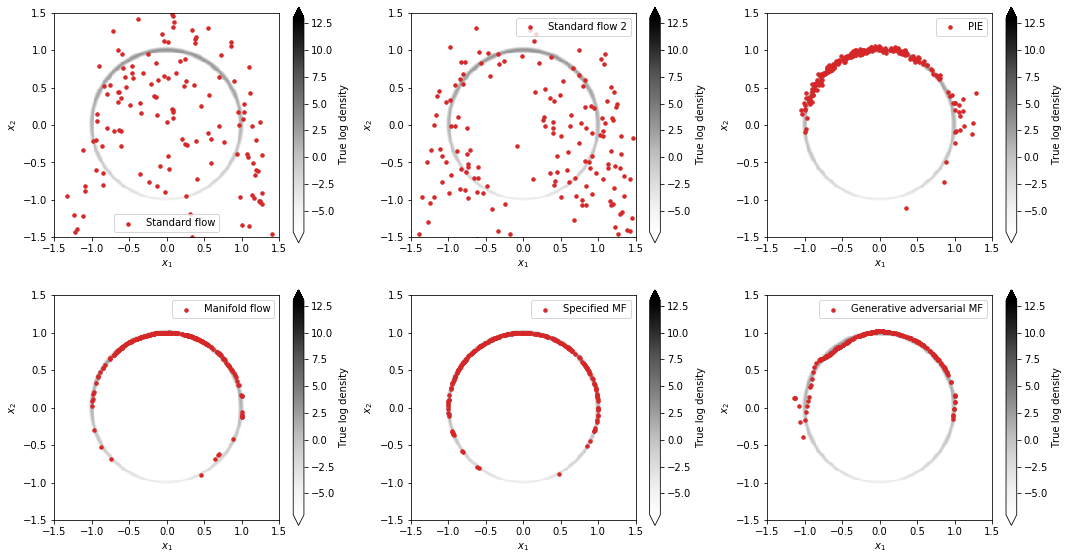

In [33]:
skip = 4
res = 250
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
logp_grid = simulator.log_density(x_grid).reshape((res, res))
logp_grid[~np.isfinite(logp_grid)] = -1000000.
zmin, zmax = np.max(logp_grid) - 10., np.max(logp_grid)+ 10.

fig = plt.figure(figsize=(15,8))

for i, (label, x) in enumerate(zip(
    ["Standard flow", "Standard flow 2", "PIE", "Manifold flow", "Specified MF",  "Generative adversarial MF"],
    [x_gen_sf, x_gen_sf2, x_gen_pie_full, x_gen_mf, x_gen_smf, x_gen_gamf]
     )):
    ax = plt.subplot(2,3,i+1)

    pcm = plt.imshow(
        np.clip(logp_grid, zmin, zmax),
        extent=(-1.5,1.5,-1.5,1.5),
        origin="lower",
        cmap="Greys",
        norm=matplotlib.colors.Normalize(zmin, zmax),
        interpolation='nearest'
    )
    cb = plt.colorbar(pcm, extend="both")
    plt.scatter(x[::skip,0], x[::skip,1], s=12., c="C3", label=label)

    plt.legend()

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    cb.set_label("True log density")

plt.tight_layout()
plt.savefig("../figures/spherical_gaussian_2d_generation.pdf")


## Visualize learned likelihoods

### Calculate log likelihood on grid

In [34]:
res = 200
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)

learned_logp_grid_sf = sf.log_prob(x_grid_tensor).detach().numpy().reshape((res, res))
learned_logp_grid_sf2 = sf2.log_prob(x_grid_tensor).detach().numpy().reshape((res, res))
learned_logp_grid_pie = pie.log_prob(x_grid_tensor, mode="pie").detach().numpy().reshape((res, res))

# learned_logp_grid_mf = mf.log_prob(x_grid_tensor, mode="mf").detach().numpy().reshape((res, res))
# learned_logp_grid_slice_of_pie = slice_of_pie.log_prob(x_grid_tensor, mode="slice").detach().numpy().reshape((res, res))

logp_grid_truth = simulator.log_density(x_grid).reshape((res, res))
logp_grid_truth[~np.isfinite(logp_grid_truth)] = -1000000.


../../experiments/simulators/spherical_simulator.py:99: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=self._epsilon).pdf(z_eps))


### Calculate along manifold

In [35]:
def likelihood_along_manifold(model, mode, zmin=-5., zmax=5., n_samples=100, epsilon=0.02):
    # Sample
    u = torch.linspace(zmin, zmax, n_samples).view(-1,1)
    x = model.sample(n=n_samples, u=u).detach().numpy()
    
    # Interpolate
    x_interpol = [x[0]]
    for x, x_prev in zip(x[:-1], x[1:]):
        distance = np.linalg.norm(x-x_prev)
        if distance > epsilon:
            n_insert = int(distance / epsilon)
            for frac in np.linspace(0., 1., n_insert + 2)[1:-1]:
                x_interpol.append(x_prev + frac * (x-x_prev))
        x_interpol.append(x)
    x_interpol.append(x)
    x_interpol = np.array(x_interpol)

    # Evaluate likelihood
    log_probs = model.log_prob(torch.FloatTensor(x_interpol), mode=mode).detach().numpy()

    # Return
    return x_interpol, log_probs

In [36]:
x_manifold_mf, learned_logp_manifold_mf = likelihood_along_manifold(mf, "mf")
x_manifold_slice, learned_logp_manifold_slice = likelihood_along_manifold(slice_of_pie, "slice")
x_manifold_gamf, learned_logp_manifold_gamf = likelihood_along_manifold(gamf, "mf")
x_manifold_hybrid, learned_logp_manifold_hybrid = likelihood_along_manifold(hybrid, "mf")
x_manifold_smf, learned_logp_manifold_smf = likelihood_along_manifold(smf, "mf")


### Plot likelihoods

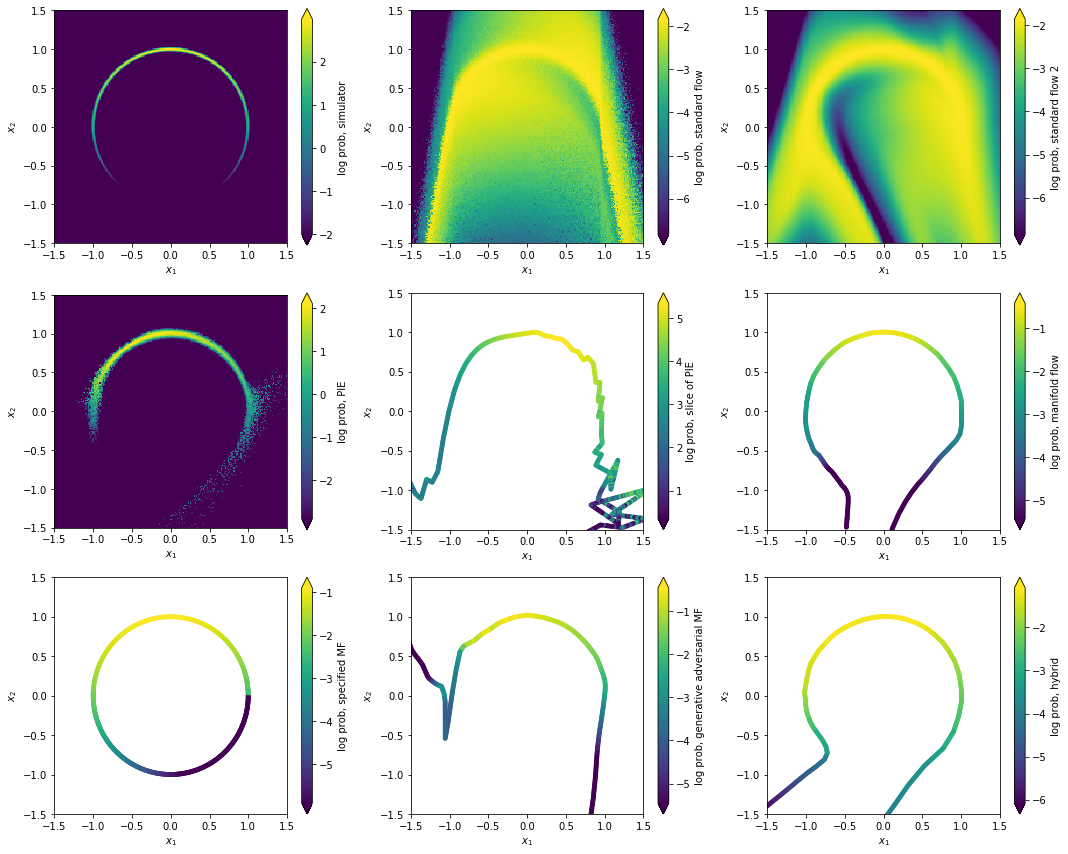

In [37]:
fig = plt.figure(figsize=(15,12))

for i, (label, logp, x) in enumerate(zip(
    ["simulator", "standard flow", "standard flow 2", "PIE",
     "slice of PIE", "manifold flow", "specified MF",
     "generative adversarial MF", "hybrid"],
    [logp_grid_truth, learned_logp_grid_sf, learned_logp_grid_sf2, learned_logp_grid_pie,
     learned_logp_manifold_slice, learned_logp_manifold_mf, learned_logp_manifold_smf,
     learned_logp_manifold_gamf, learned_logp_manifold_hybrid],
    [None, None, None, None,
     x_manifold_slice, x_manifold_mf, x_manifold_smf,
     x_manifold_gamf, x_manifold_hybrid]
     )):
    ax = plt.subplot(3,3,i+1)

    zmin, zmax = np.max(logp) - 5., np.max(logp)

    if x is None:
        pcm = plt.imshow(
            np.clip(logp, zmin, zmax),
            extent=(-1.5, 1.5, -1.5, 1.5),
            origin="lower",
            cmap="viridis",
            norm=matplotlib.colors.Normalize(zmin, zmax),
            interpolation='nearest'
        )
    else:
        pcm = plt.scatter(
            x[:,0], x[:,1],
            c=np.clip(logp, zmin, zmax),
            s=15.,
            cmap="viridis",
            norm=matplotlib.colors.Normalize(zmin, zmax),
        )
    cb = plt.colorbar(pcm, extend="both")

    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    cb.set_label("log prob, " + label)
    
plt.tight_layout()
plt.savefig("../figures/spherical_gaussian_2d_log_prob.pdf", dpi=600)


## Plot reconstruction performance

In [ ]:
x_in = SphericalGaussianSimulator(1,2,epsilon=10*epsilon).sample(100)
x_in = torch.FloatTensor(x_in)
x_out = mf(x_in)[0]
x_in, x_out = x_in.detach().numpy(), x_out.detach().numpy()
dx = x_out - x_in

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
plt.scatter(x_in[:,0], x_in[:,1], s=15., c="C1")
plt.scatter(x_out[:,0], x_out[:,1], s=15., c="C0")
plt.quiver(
    x_in[:,0], x_in[:,1], dx[:,0], dx[:,1],
    angles='xy', scale_units='xy', scale=1., width=2.e-3, alpha=1.
)

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()

plt.savefig("../figures/spherical_gaussian_2d_mf_reco.pdf")


## Model anatomy

In [ ]:
def make_anatomy_plot(model, name, res=25):
    x_range = np.linspace(-1.5,1.5,res)
    y_range = np.linspace(-1.5,1.5,res)
    xx, yy = np.meshgrid(x_range, y_range)
    x = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
    x = torch.FloatTensor(x)
    x.requires_grad = True

    # Encode
    u, h_manifold, h_orthogonal, log_det_outer, log_det_inner = model._encode(x)

    # Decode
    x_reco, _, _, inv_jacobian_outer = model._decode(u, mode="mf")
    _, inv_log_det_inner, inv_log_det_outer, _ = model._decode(u, mode="slice")

    # inv_jacobian_outer is dx / du, but still need to restrict this to the manifold latents
    inv_jacobian_outer = inv_jacobian_outer[:, :, : model.latent_dim]
    # And finally calculate log det (J^T J)
    jtj = torch.bmm(torch.transpose(inv_jacobian_outer, -2, -1), inv_jacobian_outer)
    mf_log_det_outer = - 0.5 * torch.slogdet(jtj)[1]

    # Base log prob
    log_prob_latent = model.manifold_latent_distribution._log_prob(u, context=None)
    
    # Plot
    fig = plt.figure(figsize=(12,9))

    for panel, (label, quantity, diverging) in enumerate(zip(
        ["Perp latent", "Manifold latent after outer flow", "Manifold latent after inner flow",
         "log det outer (PIE)", "log det inner", "Base log prob",
         "log det outer (MF)", "log det outer (Slice of PIE)", "delta log det outer (MF - Slice)"],
        [h_orthogonal, h_manifold, u,
         log_det_outer, - log_det_inner, log_prob_latent,
         mf_log_det_outer, - inv_log_det_outer, mf_log_det_outer + inv_log_det_outer],
        [True, True, True, False, False, False, False, False, False]
    )):
        ax = plt.subplot(3,3,panel+1)

        quantity_ = quantity.detach().numpy()
        quantity_ = quantity_.flatten() + np.zeros((res**2))

        if diverging:
            zmin, zmax = - 2. * np.std(quantity_), 2. * np.std(quantity_)
        else:
            zmin, zmax = np.mean(quantity_) - 1.5 * np.std(quantity_), np.mean(quantity_) + 1.5 * np.std(quantity_)

        pcm = plt.imshow(
            np.clip(quantity_, zmin, zmax).reshape(res, res),
            extent=(-1.5, 1.5, -1.5, 1.5),
            origin="lower",
            cmap="PRGn" if diverging else "viridis",
            norm=matplotlib.colors.Normalize(zmin, zmax),
            interpolation='nearest'
        )
        cb = plt.colorbar(pcm, extend="both")
        # plt.scatter(x_gen_mf[::10,0], x_gen_mf[::10,1], s=3., c="black")

        plt.xlim(-1.5,1.5)
        plt.ylim(-1.5,1.5)
        plt.xlabel("$x_1$")
        plt.ylabel("$x_2$")
        cb.set_label(label)
        plt.tight_layout()

    plt.savefig("../figures/spherical_gaussian_2d_{}_anatomy.pdf".format(name))

In [ ]:
make_anatomy_plot(mf, "mf")

In [ ]:
make_anatomy_plot(slice_of_pie, "slice")

In [ ]:
make_anatomy_plot(pie, "pie")

In [ ]:
make_anatomy_plot(gamf, "gamf")

In [ ]:
make_anatomy_plot(hybrid, "hybrid")

In [ ]:
make_anatomy_plot(smf, "smf")